In [1]:
import os
from random import shuffle
import json
from itertools import product, combinations
from time import perf_counter

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.animation as animation

from src.models.monuseg.models import get_model
from src.data.monuseg.tf_data import get_dataset, tf_random_crop
from src.models.loss import dice_coe_loss, dice_coe_metric
from src.models.monuseg.evaluation import post_processing, post_processing_new
from src.models.monuseg.metrics import confusion_indices
from src.models.monuseg.train_model import eval

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

path_indices = "/home/valentin/python_wkspce/2d_bispectrum_cnn/data/indices/monuseg.json"
split = 9

In [2]:
w_fg = 1.9
w_border = 5.0
w_bg = 0.44


def loss(y_true, y_pred):
    l = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    w = (y_true[..., 0] * w_fg + y_true[..., 1] * w_border +
         y_true[..., 2] * w_bg)
    return tf.reduce_mean(w * l, axis=(1, 2))

In [3]:
with open(path_indices, "r") as f:
    indices_list = json.load(f)

ds_train = get_dataset(id_list=indices_list[split]["train"]).take(1)
ds_train = ds_train.cache().repeat(15)
f1 = lambda image, seg: tf_random_crop(
    image, seg, rotation_angle="right-angle")
f2 = lambda image, seg: (
    tf.image.random_brightness(image, max_delta=0.2),
    seg,
)
ds_train = ds_train.map(f1).map(f2).batch(4)

ds_val = get_dataset(id_list=indices_list[split]["val"])
ds_val = ds_val.cache().batch(1)

ds_val_instance = get_dataset(id_list=indices_list[split]["val"],
                              instance=True)
ds_val_instance = ds_val_instance.cache().batch(1)

ds_test = get_dataset(id_list=indices_list[split]["test"], instance=False)
ds_test = ds_test.cache().batch(1)


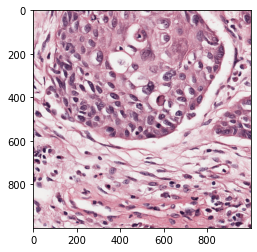

In [4]:
images, segs = next(ds_test.as_numpy_iterator())
plt.imshow(images[0,...])

In [50]:
def rotate_batch(images, angle=90, order=1, binary=False):
    output = np.zeros_like(images)
    for n in range(images.shape[0]):
        out = rotate(images[n, ...], angle=angle, reshape=False, order=order)
        if binary:
            out = (out > 0.5).astype(images.dtype)

        output[n, ...] = out
    return output


In [6]:
model = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=8,
    n_feature_maps=[8, 16, 32],
    radial_profile_type="disks",
)


In [7]:
ds_sample = ds_test.as_numpy_iterator()

In [8]:
x, y = next(ds_sample)

In [9]:
x.shape

(1, 1000, 1000, 3)

In [10]:
x = x[:, :256, :256, :]
y = y[:, :256, :256, :]
x.shape

(1, 256, 256, 3)

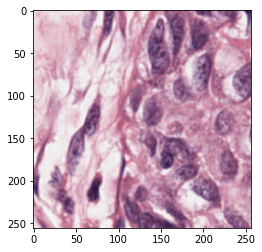

In [11]:
plt.imshow(x[0,...])

In [12]:
x_c = x[:, 100:180, 125:205, :]
y_c = y[:, 100:180, 125:205, :]


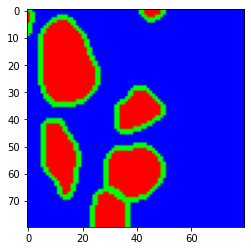

In [13]:
plt.imshow(y_c[0,...])

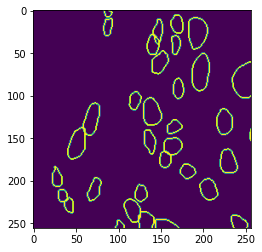

In [14]:
plt.imshow(y[0, :, :, 1])


In [15]:
y_pred = model(x)

In [16]:
model.load_weights(
    f"/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/"
    f"BispectUnet__rotation_True__nh_8__n_train_-1__psize_60x60__20211202-173734"
    f"/weights/split_{split}/final")


In [17]:
angle = 90
x_rotated = rotate_batch(x, angle=angle)

In [18]:
y_pred = model(x)
y_pred_2 = rotate_batch(model(x_rotated), -angle)

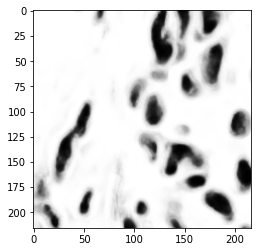

In [19]:
plt.imshow(y_pred[0,:,:,0], cmap="binary")

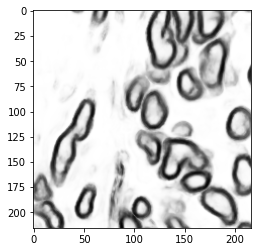

In [20]:
plt.imshow(y_pred[0,:,:,1], cmap="binary")

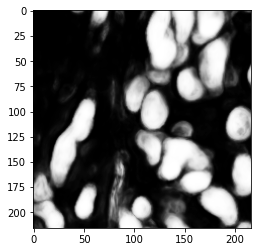

In [21]:
plt.imshow(y_pred[0,:,:,2], cmap="binary")

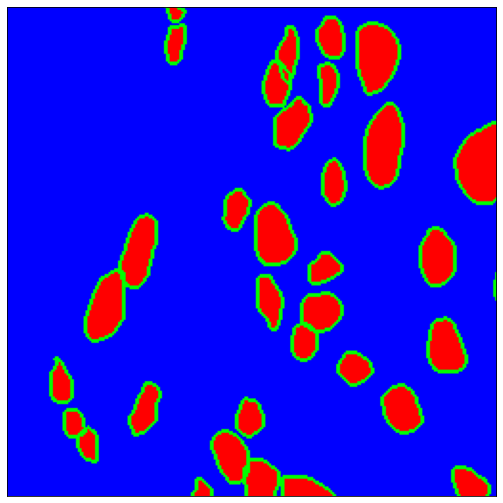

In [22]:
plt.figure(figsize=(9, 9))
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.imshow(y[0, ...])

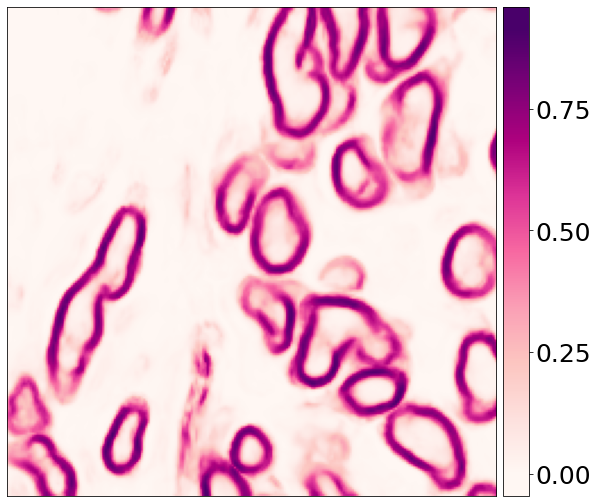

In [23]:
fig = plt.figure(figsize=(9, 9))
ax = plt.axes()
im = ax.imshow(y_pred[0, :, :, 1], cmap="RdPu")
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
cax = fig.add_axes([
    ax.get_position().x1 + 0.01,
    ax.get_position().y0, 0.04,
    ax.get_position().height
])
cbar = plt.colorbar(im,
                  cax=cax,
                  extend="both",
                  extendrect=True,
                  ticks=np.linspace(0, 1, 5))
cbar.ax.tick_params(labelsize=25)


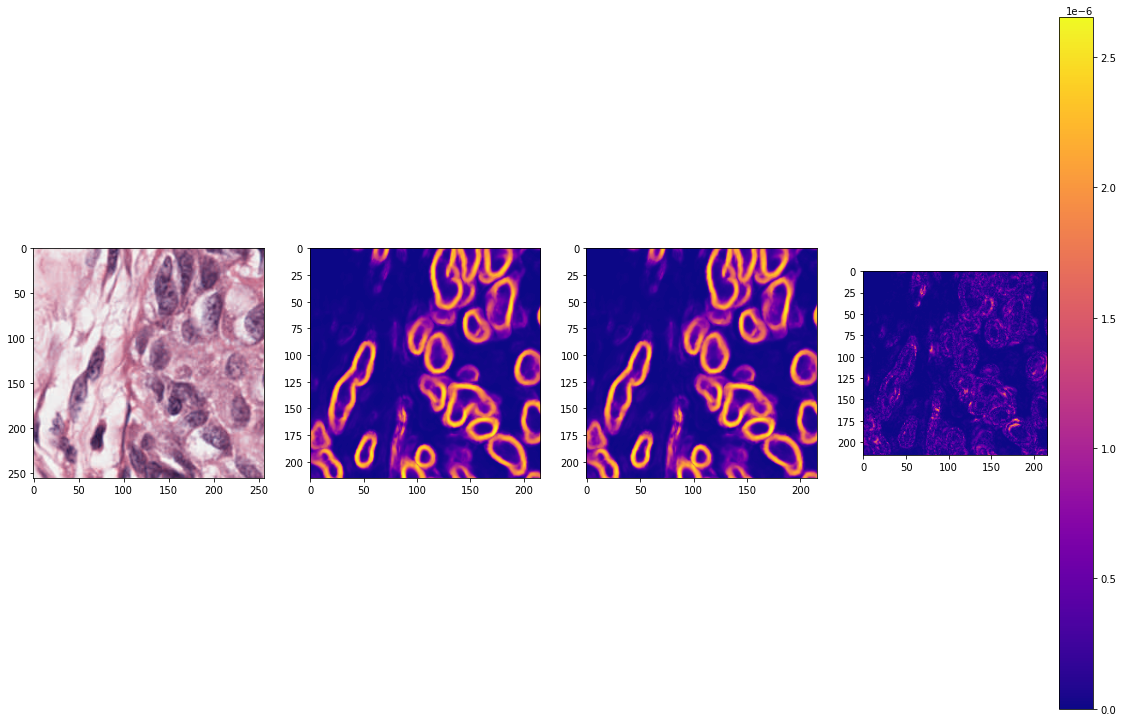

In [24]:
fig = plt.figure(figsize=(19, 19))
plt.subplot(141)
plt.imshow(x[0, ...])
plt.subplot(142)
plt.imshow(y_pred[0, :, :, 1], cmap="plasma")
plt.subplot(143)
plt.imshow(y_pred_2[0, :, :, 1], cmap="plasma")
ax = plt.subplot(144)
im = ax.imshow(np.abs(y_pred - y_pred_2)[0, :, :, 1], cmap="plasma")
fig.colorbar(im, ax=ax)


In [25]:
unet = get_model(
    # model_name="MaskedUnet",
    model_name="Unet",
    output_channels=3,
    n_feature_maps=[8, 16, 32],
)


In [26]:
# unet.load_weights(
#     "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/MaskedUnet__rotation_True__nh_0__n_train_-1__psize_60x60__20211212-222429/weights/split_0/final"
# )

unet.load_weights(
    f"/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/"
    f"Unet__rotation_False__nh_0__n_train_-1__psize_60x60__rtype_None20211215-111810"
    f"/weights/split_{split}/final"
)

In [27]:
y_pred_2 = unet(x)
y_pred_2 = rotate_batch(unet(x_rotated), -angle)

In [41]:
def compute_image_error(model,
                        x,
                        ouput_shape=(1, 216, 216, 3),
                        rotations=None):
    if rotations is None:
        rotations = [0, 45, 90, 135, 180, 225, 270, 315],
    errors = np.zeros(ouput_shape)
    n = 0
    for r1, r2 in combinations(rotations, 2):
        pred_1 = rotate_batch(model(rotate_batch(x, r1)), -r1)
        pred_2 = rotate_batch(model(rotate_batch(x, r2)), -r2)
        errors += np.sqrt((pred_1 - pred_2)**2)
        n += 1
    return errors / n


def compute_rotated_prediction(
    model,
    x,
    rotations=None,
    return_x=False,
    realign=True,
):
    if rotations is None:
        rotations = [0, 45, 90, 135, 180, 225, 270, 315],
    preds = []
    if return_x:
        xs = []
    for r in rotations:
        xr = rotate_batch(x, r)
        if realign:
            preds.append(rotate_batch(model(xr), -r))
        else:
            preds.append(model(xr))
        if return_x:
            xs.append(xr)

    if return_x:
        return preds, xs

    return preds


def colorize(y_pred):
    indices = np.unique(y_pred)
    indices = np.delete(indices, 0)
    output = np.zeros(y_pred.shape + (3, ))
    for i in indices:
        color = np.random.uniform(size=(3, ))
        positions = np.where(y_pred == i)
        output[positions[0], positions[1], :] = color
    return output

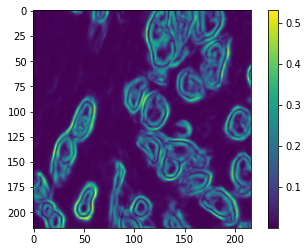

In [29]:
errors = compute_image_error(unet, x,rotations=[0,90,180,270])
plt.imshow(errors[0,:,:,1])
plt.colorbar()

In [30]:
np.max(errors[0,:,:,1])

0.5304373254378637

In [31]:
def disk(size):
    output = np.zeros((size, size))
    x = np.linspace(-size // 2, size // 2, num=size)
    x, y = np.meshgrid(x, x, indexing="xy")
    radius = np.sqrt(x**2 + y**2)
    output[radius < size // 2] = 1
    return output


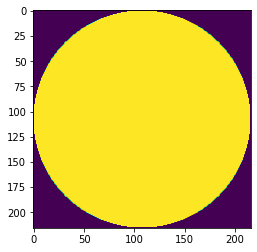

In [32]:
plt.imshow(disk(216))

In [33]:
x[0, ...].shape


(256, 256, 3)

In [34]:
delta_deg = 45
rotations = [k * delta_deg for k in range(int(360 / delta_deg))]

<Figure size 648x648 with 0 Axes>

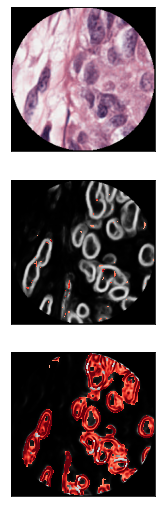

In [35]:
plt.figure(figsize=(9, 9))
fig, axs = plt.subplots(3, 1, figsize=(9, 9))
# cmaps = [None, 'binary', 'binary']
cmaps = [None, 'gray', 'gray']
mask_disk = disk(216)
images = [x[0, ...], model(x)[0, :, :, 1], unet(x)[0, :, :, 1]]
images_error = [
    np.zeros((216, 216)),
    compute_image_error(model, x, rotations=rotations)[0, :, :, 1] * disk(216),
    compute_image_error(unet, x, rotations=rotations)[0, :, :, 1] * disk(216),
]
for row in range(3):
    ax = axs[row]
    if row > 0:
        pcm = ax.imshow(images[row] * mask_disk,
                        cmap=cmaps[row],
                        vmin=0.0,
                        vmax=1.0)
        # plt.colorbar(pcm)
    else:
        im = tf.keras.layers.Cropping2D((20, 20))(images[row][np.newaxis, ...])
        pcm = ax.imshow(im[0, ...] * mask_disk[..., np.newaxis],
                        cmap=cmaps[row])
    masked = np.ma.masked_where(images_error[row] < 0.05, images_error[row])
    err = ax.imshow(masked, cmap="Reds", alpha=0.99, vmin=0.0, vmax=0.2)
    # plt.colorbar(err)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
plt.savefig("sample_2.png", bbox_inches='tight')

In [36]:
n_rotations = 32
rotations = [k * 360 / n_rotations for k in range(n_rotations)]
y_preds_model, xs = compute_rotated_prediction(
    model,
    x_c,
    rotations=rotations,
    return_x=True,
)
y_preds_unet = compute_rotated_prediction(unet, x_c, rotations=rotations)


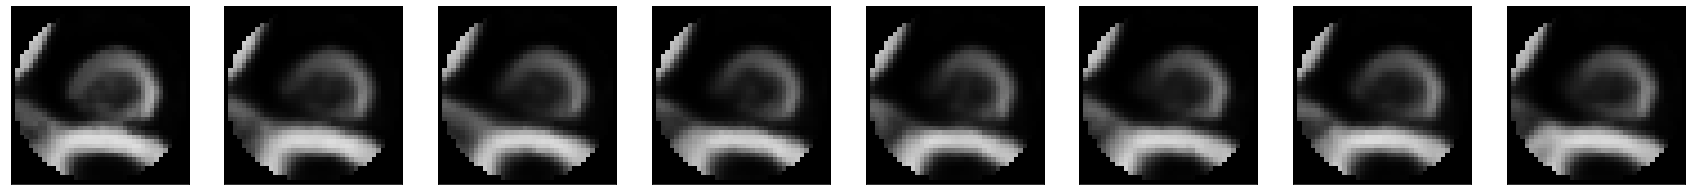

In [37]:
fig, axs = plt.subplots(1, 8, figsize=(30, 6))
for row in range(8):
    ax = axs[row]
    pcm = ax.imshow(y_preds_model[row][0, :, :, 1] * disk(40),
                    cmap="gray",
                    vmin=0.0,
                    vmax=1.0)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [38]:
np.mean(y_preds_model)

0.28791663

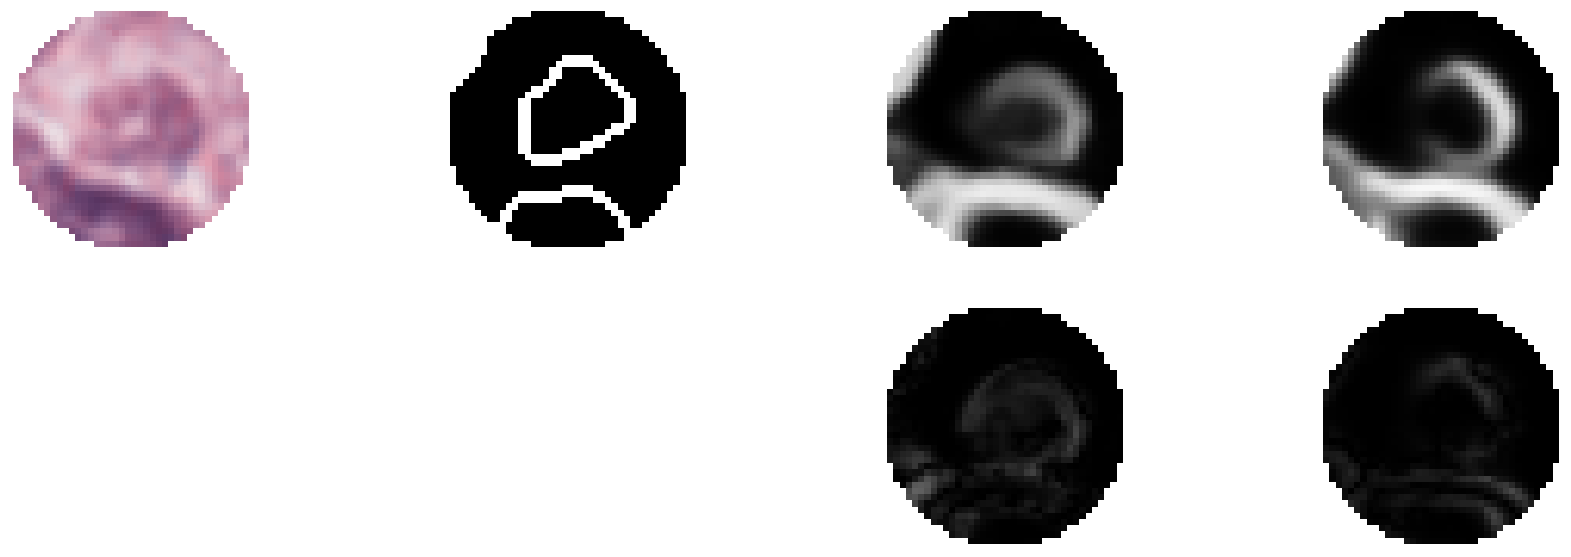

In [40]:
frames = []  # for storing the generated images
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(2, 4, 1)
ax2 = fig.add_subplot(2, 4, 2)
ax3 = fig.add_subplot(2, 4, 3)
ax4 = fig.add_subplot(2, 4, 4)
ax5 = fig.add_subplot(2, 4, 7)
ax6 = fig.add_subplot(2, 4, 8)
# ax1.title.set_text("Input \n")
# ax2.title.set_text("Groud Truth \n")
# ax3.title.set_text("Bispectrum \n U-Net")
# ax4.title.set_text("Standard \n U-Net")
n_repeat = 5
y_cropped = tf.keras.layers.Cropping2D((20, 20))(y_c)[..., 1]
mask_disk = disk(40)
for i in range(n_rotations):

    im_in = tf.keras.layers.Cropping2D((20, 20))(xs[i])
    im1 = ax1.imshow(im_in[0, ...] * mask_disk[..., np.newaxis] +
                     (1 - mask_disk[..., np.newaxis]),
                     animated=True)
    im2 = ax2.imshow(y_cropped[0, ...] * mask_disk + (1 - mask_disk),
                     cmap=cm.Greys_r,
                     vmin=0.0,
                     vmax=1.0,
                     animated=True)

    im3 = ax3.imshow(y_preds_model[i][0, :, :, 1] * mask_disk +
                     (1 - mask_disk),
                     cmap=cm.Greys_r,
                     vmin=0.0,
                     vmax=1.0,
                     animated=True)
    im4 = ax4.imshow(y_preds_unet[i][0, :, :, 1] * mask_disk + (1 - mask_disk),
                     cmap=cm.Greys_r,
                     vmin=0.0,
                     vmax=1.0,
                     animated=True)

    im5 = ax5.imshow(
        np.abs(y_preds_model[i][0, :, :, 1] - y_preds_model[0][0, :, :, 1]) *
        mask_disk + (1 - mask_disk),
        cmap=cm.Greys_r,
        vmin=0.0,
        vmax=1.0,
        animated=True)
    im6 = ax6.imshow(
        np.abs(y_preds_unet[i][0, :, :, 1] - y_preds_unet[0][0, :, :, 1]) *
        mask_disk + (1 - mask_disk),
        cmap=cm.Greys_r,
        vmin=0.0,
        vmax=1.0,
        animated=True)

    im1.axes.axis('off')
    im2.axes.axis('off')
    im3.axes.axis('off')
    im4.axes.axis('off')
    im5.axes.axis('off')
    im6.axes.axis('off')
    frames.append([im1, im2, im3, im4, im5, im6])

ani = animation.ArtistAnimation(
    fig,
    n_repeat * frames,
    interval=125,
    blit=True,
    repeat=False,
)
ani.save('movie.mp4')

In [79]:
n_rotations = 32
rotations = [k * 360 / n_rotations for k in range(n_rotations)]
y_preds_unet, xs = compute_rotated_prediction(
    unet,
    x,
    rotations=rotations,
    return_x=True,
    realign=False,
)
gts = []
for r in rotations:
    gts.append(rotate_batch(y, r, order=3, binary=True))

y_pred_unet = unet(x)
y_preds_pre = []
for r in rotations:
    y_preds_pre.append(rotate_batch(y_pred_unet, r, order=1, binary=False))

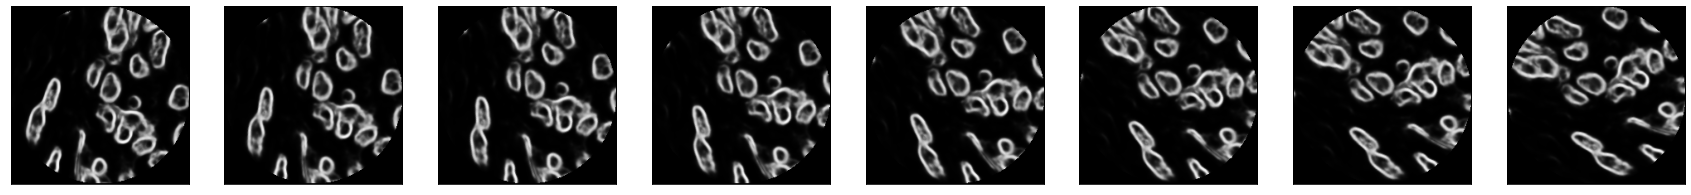

In [80]:
fig, axs = plt.subplots(1, 8, figsize=(30, 6))
for row in range(8):
    ax = axs[row]
    # y_ppre = tf.keras.layers.Cropping2D((20, 20))(y_preds_pre[row])
    pcm = ax.imshow(y_preds_pre[row][0, :, :, 1] * disk(216),
                    cmap="gray",
                    vmin=0.0,
                    vmax=1.0)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

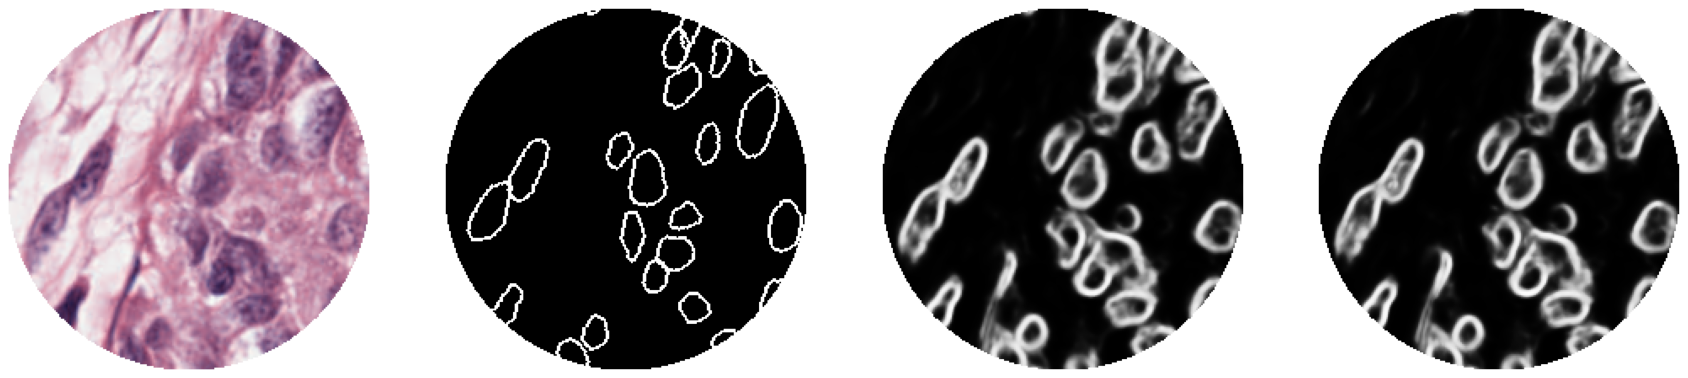

In [81]:
frames = []  # for storing the generated images
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)
n_repeat = 5
mask_disk = disk(216)
for i in range(n_rotations):

    y_cropped = tf.keras.layers.Cropping2D((20, 20))(gts[i])
    im_in = tf.keras.layers.Cropping2D((20, 20))(xs[i])
    im1 = ax1.imshow(im_in[0, ...] * mask_disk[..., np.newaxis] +
                     (1 - mask_disk[..., np.newaxis]),
                     animated=True)
    im2 = ax2.imshow(y_cropped[0, :, :, 1] * mask_disk + (1 - mask_disk),
                     cmap=cm.Greys_r,
                     animated=True)

    im3 = ax3.imshow(y_preds_pre[i][0, :, :, 1] * mask_disk + (1 - mask_disk),
                     cmap=cm.Greys_r,
                     animated=True)
    im4 = ax4.imshow(y_preds_unet[i][0, :, :, 1] * mask_disk + (1 - mask_disk),
                     cmap=cm.Greys_r,
                     animated=True)
    im1.axes.axis('off')
    im2.axes.axis('off')
    im3.axes.axis('off')
    im4.axes.axis('off')
    frames.append([im1, im2, im3, im4])

ani = animation.ArtistAnimation(
    fig,
    n_repeat * frames,
    interval=125,
    blit=True,
    repeat=False,
)
ani.save('movie_intro_zoomed_out.mp4')

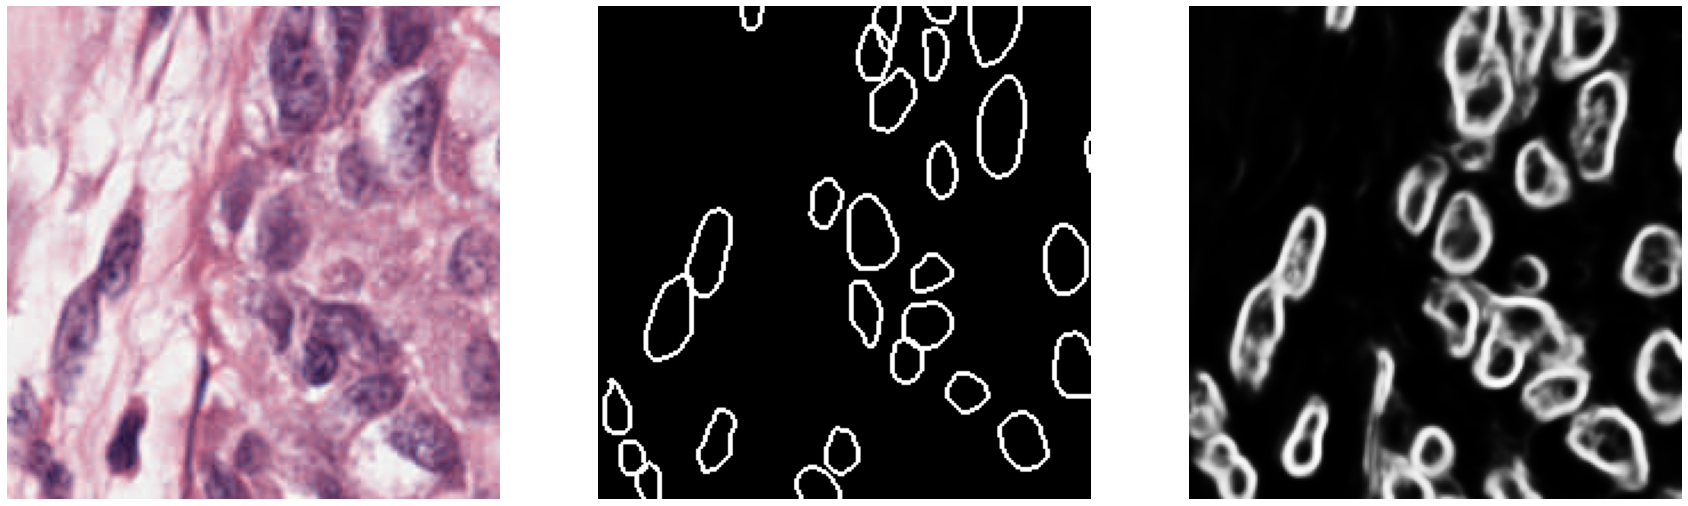

In [83]:
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
mask_disk = disk(216)
i = 0
y_cropped = tf.keras.layers.Cropping2D((20, 20))(gts[i])
im_in = tf.keras.layers.Cropping2D((20, 20))(xs[i])
im1 = ax1.imshow(im_in[0, ...])
im2 = ax2.imshow(y_cropped[0, :, :, 1],
    cmap=cm.Greys_r,
)

im3 = ax3.imshow(
    y_preds_pre[i][0, :, :, 1],
    cmap=cm.Greys_r,
)
im1.axes.axis('off')
im2.axes.axis('off')
im3.axes.axis('off')
im4.axes.axis('off')
plt.savefig('intro_zoomed_out.png', dpi=300)

In [ ]:
frames = []  # for storing the generated images
fig = plt.figure()
n_repeat = 5
for i in range(n_rotations):

    frame = plt.imshow(y_preds_unet[i][0, :, :, 1] * mask_disk +
                       (1 - mask_disk),
                       cmap=cm.Greys_r,
                       animated=True)
    frame.imshow(y_preds_unet[i][0, :, :, 1] * mask_disk + (1 - mask_disk),
                 cmap=cm.Greys_r,
                 animated=True)

    plt.axis('off')
    frames.append([frame])

ani = animation.ArtistAnimation(
    fig,
    n_repeat * frames,
    interval=500,
    blit=True,
    repeat=False,
)
ani.save('movie_standard_unet.mp4')

In [ ]:
np.min(images_error[1][disk(216)!=0])

In [ ]:
def evaluate_forward_time(model, images, n_rep=10):
    t1 = perf_counter()
    n_images = 0
    for _ in range(n_rep):
        for x in images:
            y_pred = model(x)
            n_images += 1
    t2 = perf_counter()
    return {
        "elapsed_time": t2 - t1,
        "n_images": n_images,
        "average_elapsed_time": (t2 - t1) / n_images,
    }


In [ ]:
images = list()
for x, _ in ds_test:
    images.append(x)

In [ ]:
len(images)

In [ ]:
unet_nhx = get_model(
    model_name="BispectUnet",
    output_channels=3,
    n_harmonics=3,
    n_feature_maps=[8, 16, 32],
    radial_profile_type="disks",
)

In [ ]:

unet_nhx.load_weights(
    "/home/valentin/python_wkspce/2d_bispectrum_cnn/models/MoNuSeg/BispectUnet__rotation_True__nh_3__n_train_-1__psize_60x60__20211212-222438/weights/split_0/final"
)

In [ ]:
# evaluate_forward_time(unet_nhx, images)

In [ ]:
# evaluate_forward_time(model, images)

In [ ]:
# evaluate_forward_time(unet, images)

In [ ]:
n, bins, patches = plt.hist(x=images_error[1][disk(216)!=0].flatten(), bins='auto', 
                            alpha=0.7, rwidth=0.85)

In [ ]:
n, bins, patches = plt.hist(x=images_error[2][disk(216)!=0].flatten(), bins='auto', 
                            alpha=0.7, rwidth=0.85)

In [ ]:
def confusion_indices_dev(y_true, y_pred):
    y_true_indices = np.unique(y_true)
    y_pred_indices = np.unique(y_pred)

    y_true_indices = np.delete(y_true_indices, y_true_indices == 0)
    y_pred_indices = np.delete(y_pred_indices, y_pred_indices == 0)

    matched_pred_indices = list()
    unmatched_true_indices = list()
    for i in y_true_indices:
        nuclei_mask = y_true == i
        y_pred_match = nuclei_mask * y_pred
        nuclei_area = np.sum(nuclei_mask)

        if np.sum(y_pred_match) == 0:
            unmatched_true_indices.append(i)
            continue
        else:
            pred_nuclei_indices = np.unique(y_pred_match)
            pred_nuclei_indices = np.delete(pred_nuclei_indices,
                                            pred_nuclei_indices == 0)
            matched = False
            for j in pred_nuclei_indices:
                if j not in matched_pred_indices:
                    if np.sum(y_pred_match == j) > 0.5 * nuclei_area:
                        matched_pred_indices.append(j)
                        matched = True
                        break

            if not matched:
                unmatched_true_indices.append(i)

    unmatched_pred_indices = list(
        set(y_pred_indices) - set(matched_pred_indices))
    return matched_pred_indices, unmatched_pred_indices, unmatched_true_indices


In [ ]:
def random_crop(*args, size=(256, 256)):
    _, w, h, _ = args[0].shape
    origin_x = np.random.randint(0, high=w - size[0])
    origin_y = np.random.randint(0, high=h - size[1])
    outputs = list()
    for array in args:
        outputs.append(array[:, origin_x:origin_x + size[0],
                            origin_y:origin_y + size[1], :])
    return outputs

In [ ]:
def colorize(y_pred):
    indices = np.unique(y_pred)
    indices = np.delete(indices, 0)
    output = np.zeros(y_pred.shape + (3, ))
    for i in indices:
        color = np.random.uniform(size=(3, ))
        positions = np.where(y_pred == i)
        output[positions[0], positions[1], :] = color
    return output


In [ ]:
def fscore(tp, fp, fn):
    return tp / (tp + 0.5 * (fp + fn))


In [ ]:
cropper = tf.keras.layers.Cropping2D((20, 20))

In [ ]:
for x, y in ds_test.take(3).as_numpy_iterator():
    pass
x, y = random_crop(x,y)

In [ ]:
y_c = cropper(y).numpy()[0, :, :, 0]

In [ ]:
# find missing predictions in bisp not in standard
# opposite
# same for FP
(matched_pred_bisp, unmatched_pred_bisp,
 unmatched_true_bisp) = confusion_indices_dev(y_c, post_processing(model(x)))
fp = len(unmatched_pred_bisp)
fn = len(unmatched_true_bisp)
tp = len(matched_pred_bisp)
print(f"fscore is {fscore(tp,fp,fn)}")

In [ ]:

(matched_pred_unet, unmatched_pred_unet,
 unmatched_true_unet) = confusion_indices_dev(y_c, post_processing(unet(x)))
fp = len(unmatched_pred_unet)
fn = len(unmatched_true_unet)
tp = len(matched_pred_unet)
print(f"fscore is {fscore(tp,fp,fn)}")

In [ ]:
ncols = 3
nrows = 4
fig, axs = plt.subplots(ncols, nrows, figsize=(4, 3))
images = [
    cropper(x)[0, ...],
    colorize(post_processing(model(x))[0, ...]),
    colorize(post_processing(unet(x))[0, ...]),
    colorize(cropper(y)[0, :, :, 0]),
    None,
    model(x)[0, :, :, 1],
    unet(x)[0, :, :, 1],
    None,
    None,
    model(x)[0, :, :, 0],
    unet(x)[0, :, :, 0],
    None,
]
cmaps = [
    None, 'gray', 'gray', 'gray', None, "binary", "binary", None, None,
    "binary", "binary", None
]
for i, (r, c) in enumerate(product(range(ncols), range(nrows))):
    if images[i] is not None:
        pcm = axs[r, c].imshow(images[i], cmap=cmaps[i])
        axs[r, c].axes.xaxis.set_visible(False)
        axs[r, c].axes.yaxis.set_visible(False)
    else:
        axs[r, c].axis("off")
plt.savefig("comp_pred.png", dpi=200, bbox_inches='tight')

In [ ]:
y_pred = post_processing(model(x))

In [ ]:
eval(ds=ds_test, model=model, cropper=cropper)


In [ ]:
eval(ds=ds_test, model=unet, cropper=cropper)